# FROM CT-SCANS TO STL FILES

## Context and objectives

* Develop a pipeline to convert CT-scans to STL files using a deep learning model (Pytorch initially)
* Bone segmentation regognition
* Adding all the curls of the bone to obtain a 3D model of the bone
* Automation of the process with an API, deployed on Ruby on Rails first for prototyping

## Data

* MNIST dataset for the first model

## Global imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import albumentations as A
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.interpolate
import scipy.spatial
import scipy.ndimage
import scipy.interpolate
import scipy.spatial
import scipy.ndimage
import scipy.interpolate
import scipy.spatial



In [6]:

class Config:
    DATA_DIR = Path('./data')
    OUTPUT_DIR = Path('./output')
    MODELS_DIR = Path('./models')
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @classmethod
    def create_directories(cls):
        for dir_path in [cls.DATA_DIR, cls.OUTPUT_DIR, cls.MODELS_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)



In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block((features * 8) * 2, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block((features * 4) * 2, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block((features * 2) * 2, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, 3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )


In [4]:
class BoneSegmenter:
    def __init__(self):
        self.device = Config.DEVICE
        self.model = UNet(
            in_channels=1,
            out_channels=1,
            init_features=32
        ).to(self.device)
        
        # Initialiser sans poids pré-entraînés pour le moment
        print("Initializing model with random weights...")
        
        # Option pour charger les poids plus tard si nécessaire
        self.model.eval()

    def detect_bone_edges(self, slice_data: np.ndarray) -> np.ndarray:
        """Détection des bords avec U-Net"""
        # Préparation pour U-Net
        input_tensor = torch.from_numpy(slice_data).float()
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
        input_tensor = input_tensor.to(self.device)
        
        with torch.no_grad():
            pred = self.model(input_tensor)
            pred = pred[0, 0].cpu().numpy()
            
            # Post-traitement
            pred_binary = (pred > 0.5).astype(np.uint8)
            
            # Extraction des contours
            contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            if not contours:
                return np.zeros_like(slice_data, dtype=np.uint8)
            
            # Sélection et lissage du meilleur contour
            best_contour = max(contours, key=cv2.contourArea)
            epsilon = 0.002 * cv2.arcLength(best_contour, True)
            smoothed_contour = cv2.approxPolyDP(best_contour, epsilon, True)
            
            # Création du masque final
            contour_mask = np.zeros_like(slice_data, dtype=np.uint8)
            cv2.drawContours(contour_mask, [smoothed_contour], -1, 1, 2)
            
            return contour_mask

    def train_model(self, train_loader, val_loader, epochs=100):
        """Entraînement du modèle"""
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Mode entraînement
            self.model.train()
            train_loss = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                if batch_idx % 10 == 0:
                    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                          f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            # Mode validation
            self.model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = self.model(data)
                    val_loss += criterion(output, target).item()
            
            val_loss /= len(val_loader)
            
            print(f'Epoch {epoch}: Train loss = {train_loss/len(train_loader):.6f}, '
                  f'Val loss = {val_loss:.6f}')
            
            # Sauvegarder le meilleur modèle
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_val_loss,
                }, Config.MODELS_DIR / 'unet_best.pth')

if __name__ == "__main__":
    print(f"Using device: {Config.DEVICE}")
    
    # Créer les dossiers nécessaires
    Config.create_directories()
    print("Project directories created:")
    print(f"- Data: {Config.DATA_DIR}")
    print(f"- Output: {Config.OUTPUT_DIR}")
    print(f"- Models: {Config.MODELS_DIR}")
    
    # Initialiser le segmenteur avec des poids aléatoires
    segmenter = BoneSegmenter()

Using device: cuda
Project directories created:
- Data: data
- Output: output
- Models: models
Initializing model with random weights...


## Get information from the dataset

NameError: name 'Tuple' is not defined

In [21]:
def plot_slice(image: np.ndarray, title: str = None):
    """Utility function to plot a 2D slice"""
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='bone')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    print(f"Using device: {Config.DEVICE}")
    print("Project directories created:")
    print(f"- Data: {Config.DATA_DIR}")
    print(f"- Output: {Config.OUTPUT_DIR}")
    print(f"- Models: {Config.MODELS_DIR}")

Using device: cuda
Project directories created:
- Data: data
- Output: output
- Models: models


## Model: Transformer for bone segmentation



In [22]:
class PatchEmbedding(nn.Module):
    """Convertit l'image en patches et les projette"""
    def __init__(self, img_size=224, patch_size=16, in_channels=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)   # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

class TransformerBlock(nn.Module):
    """Bloc Transformer avec attention multi-tête"""
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Attention avec skip connection
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.norm1(x)
        
        # MLP avec skip connection
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x

class BoneSegTransformer(nn.Module):
    """Transformer pour la segmentation des os"""
    def __init__(self, 
                 img_size=512, 
                 patch_size=16, 
                 in_channels=1,
                 embed_dim=256, 
                 depth=12,
                 num_heads=8,
                 mlp_ratio=4.,
                 dropout=0.1):
        super().__init__()
        
        # Embedding des patches
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Token de classification [CLS]
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Position embedding
        self.pos_embed = nn.Parameter(
            torch.zeros(1, (img_size // patch_size) ** 2 + 1, embed_dim)
        )
        
        # Blocs Transformer
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        # Décodeur pour la segmentation
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Embedding des patches
        x = self.patch_embed(x)
        
        # Ajouter le token CLS
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Ajouter position embedding
        x = x + self.pos_embed
        
        # Passer à travers les blocs Transformer
        for block in self.blocks:
            x = block(x)
        
        # Reformer l'image pour le décodeur
        B, N, C = x.shape
        H = W = int(np.sqrt(N - 1))
        x = x[:, 1:].transpose(1, 2).reshape(B, C, H, W)
        
        # Décoder vers la taille originale
        x = self.decoder(x)
        
        return x

In [23]:
import trimesh
import scipy.interpolate
import scipy.ndimage
import scipy.spatial
import scipy.ndimage
import scipy.interpolate
import scipy.spatial
import scipy.ndimage
import scipy.interpolate
import scipy.spatial

class BoneSegmenter:
    def __init__(self):
        self.device = Config.DEVICE
        self.model = BoneSegTransformer(
            img_size=512,
            patch_size=16,
            in_channels=1,
            embed_dim=256,
            depth=12,
            num_heads=8
        ).to(self.device)
        
        # Charger les poids pré-entraînés
        checkpoint = torch.load(Config.MODELS_DIR / 'bone_transformer.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

    def detect_bone_edges(self, slice_data: np.ndarray) -> np.ndarray:
        """Détection des bords avec Transformer"""
        # Préparation de l'entrée
        input_tensor = torch.from_numpy(slice_data).float()
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
        input_tensor = input_tensor.to(self.device)
        
        with torch.no_grad():
            # Prédiction
            pred = self.model(input_tensor)
            pred = pred[0, 0].cpu().numpy()
            
            # Post-traitement
            pred_binary = (pred > 0.5).astype(np.uint8)
            
            # Extraction des contours
            contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            if not contours:
                return np.zeros_like(slice_data, dtype=np.uint8)
            
            # Sélection et lissage du meilleur contour
            best_contour = max(contours, key=cv2.contourArea)
            epsilon = 0.002 * cv2.arcLength(best_contour, True)
            smoothed_contour = cv2.approxPolyDP(best_contour, epsilon, True)
            
            # Création du masque final
            contour_mask = np.zeros_like(slice_data, dtype=np.uint8)
            cv2.drawContours(contour_mask, [smoothed_contour], -1, 1, 2)
            
            return contour_mask

    def generate_3d_model(contour_volume: np.ndarray, spacing: Tuple[float, float, float]) -> trimesh.Trimesh:
        """Génère un modèle 3D à partir des contours"""
        print("Creating 3D volume from contours...")
        volume_3d = np.zeros_like(contour_volume, dtype=np.uint8)
        
        # Remplir les contours
        for i in range(contour_volume.shape[2]):
            mask = contour_volume[:, :, i]
            if np.any(mask):
                # Trouver et remplir les contours
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.fillPoly(volume_3d[:, :, i], contours, 1)
        
        # Lissage 3D
        kernel = np.ones((3,3,3), dtype=np.uint8)
        volume_3d = scipy.ndimage.binary_closing(volume_3d, kernel)
        
        # Extraire la surface avec marching cubes
        vertices, faces, normals, _ = measure.marching_cubes(
            volume_3d,
            level=0.5,
            spacing=spacing,
            gradient_direction='descent',
            step_size=1,
            allow_degenerate=False
        )
        
        # Créer le maillage
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, normals=normals)
        
        # Lisser le maillage
        mesh = mesh.smoothed(iterations=3)
        
        return mesh

    def segment_volume(self, volume: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Segmente le volume complet"""
        segmented_volume = np.zeros_like(volume, dtype=np.float32)
        contour_volume = np.zeros_like(volume, dtype=np.uint8)
        
        for i in range(volume.shape[2]):
            slice_data = volume[:, :, i]
            enhanced = self.enhance_bone_contrast(slice_data)
            contours = self.detect_bone_edges(slice_data)
            
            segmented_volume[:, :, i] = enhanced
            contour_volume[:, :, i] = contours
            
            if i % 10 == 0:
                print(f"Processed slice {i}/{volume.shape[2]}")
        
        return segmented_volume, contour_volume

In [8]:
# Cellule 4 : Utility functions
def plot_slice(image: np.ndarray, title: str = None):
    """Utility function to plot a 2D slice"""
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='bone')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import albumentations as A
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

class BoneDataset(Dataset):
    """Dataset pour les images CT et leurs masques"""
    def __init__(self, volume, masks=None, transform=None, train=True):
        self.volume = volume
        self.masks = masks
        self.transform = transform
        self.train = train
        
        # Normalisation du volume
        self.volume = (self.volume - self.volume.min()) / (self.volume.max() - self.volume.min())
        
        if masks is not None:
            self.masks = masks.astype(np.float32)

    def __len__(self):
        return self.volume.shape[2]  # Nombre de tranches

    def __getitem__(self, idx):
        # Extraire la tranche
        image = self.volume[:, :, idx]
        
        if self.masks is not None:
            mask = self.masks[:, :, idx]
        else:
            mask = np.zeros_like(image)
        
        # Appliquer les transformations
        if self.transform and self.train:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convertir en tenseurs
        image = torch.from_numpy(image).float().unsqueeze(0)  # Ajouter canal
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask

def prepare_data(volume, contours):
    """Prépare les données avec augmentation"""
    # Définir les transformations d'augmentation
    train_transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
        ], p=0.3),
    ])
    
    # Créer le dataset
    dataset = BoneDataset(volume, contours, transform=train_transform)
    
    return dataset

def train_with_cross_validation(segmenter, dataset, n_splits=5, epochs=100, batch_size=8):
    """Entraînement avec validation croisée"""
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    # Pour stocker les métriques
    fold_results = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}/{n_splits}')
        print('--------------------------------')
        
        # Créer les sous-ensembles
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=train_subsampler,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=val_subsampler,
            num_workers=4,
            pin_memory=True
        )
        
        # Réinitialiser le modèle pour chaque fold
        segmenter.model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        
        # Entraîner sur ce fold
        fold_result = segmenter.train_model(
            train_loader,
            val_loader,
            epochs=epochs,
            fold=fold
        )
        
        fold_results.append(fold_result)
        
    return fold_results

def visualize_results(image, mask, pred, epoch, batch_idx):
    """Visualise les résultats pendant l'entraînement"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image[0, 0].cpu(), cmap='bone')
    axes[0].set_title('Input Image')
    
    axes[1].imshow(mask[0, 0].cpu(), cmap='bone')
    axes[1].set_title('True Mask')
    
    axes[2].imshow(pred[0, 0].detach().cpu(), cmap='bone')
    axes[2].set_title('Predicted Mask')
    
    plt.suptitle(f'Epoch {epoch}, Batch {batch_idx}')
    plt.show()

if __name__ == "__main__":
    print(f"Using device: {Config.DEVICE}")
    Config.create_directories()
    
    # 1. Charger les données
    print("Loading data...")
    # Supposons que volume_data et contour_data sont déjà chargés
    
    # 2. Préparer le dataset
    dataset = prepare_data(volume_data, contour_data)
    
    # 3. Initialiser le segmenteur
    segmenter = BoneSegmenter()
    
    # 4. Lancer l'entraînement avec validation croisée
    results = train_with_cross_validation(
        segmenter,
        dataset,
        n_splits=5,
        epochs=100,
        batch_size=8
    )
    
    # 5. Sauvegarder et visualiser les résultats
    print("\nTraining completed!")
    print("\nMean validation loss across folds:", 
          np.mean([r['best_val_loss'] for r in results]))

Using device: cuda
Loading data...


NameError: name 'volume_data' is not defined

In [ ]:
def prepare_data(volume: np.ndarray, contours: np.ndarray):
    """Prépare les données pour l'entraînement"""
    n_slices = volume.shape[2]
    train_idx = int(n_slices * 0.8)  # 80% pour l'entraînement
    
    # Séparation train/val
    for i in range(n_slices):
        slice_data = volume[:, :, i]
        mask_data = contours[:, :, i]
        
        # Déterminer le dossier de destination
        if i < train_idx:
            save_dir = Config.DATA_DIR / 'train'
        else:
            save_dir = Config.DATA_DIR / 'val'
            
        # Sauvegarder l'image et le masque
        np.save(save_dir / 'images' / f'slice_{i:03d}.npy', slice_data)
        np.save(save_dir / 'masks' / f'slice_{i:03d}_mask.npy', mask_data)

# Utilisation
if __name__ == "__main__":
    # Charger vos données
    volume_data = ...  # Votre volume CT
    contour_data = ... # Vos contours
    
    # Préparer les données
    prepare_data(volume_data, contour_data)
    
    # Lancer l'entraînement
    train_transformer()

Using device: cuda
Loading humerus CT series...
Loading DICOM series...
Loaded volume shape: (512, 512, 102)

Metadata:
spacing: (0.352, 0.352, 0.5)
origin: (-90.0, -62.4, 511.16)
direction: (0.9999984769103537, 0.0, 0.0017453300469675206, 0.0, 1.0, 0.0, -0.0017453300469675206, 0.0, 0.9999984769103537)
size: (512, 512, 1)

Preprocessing volume...

Visualizing sample slices...


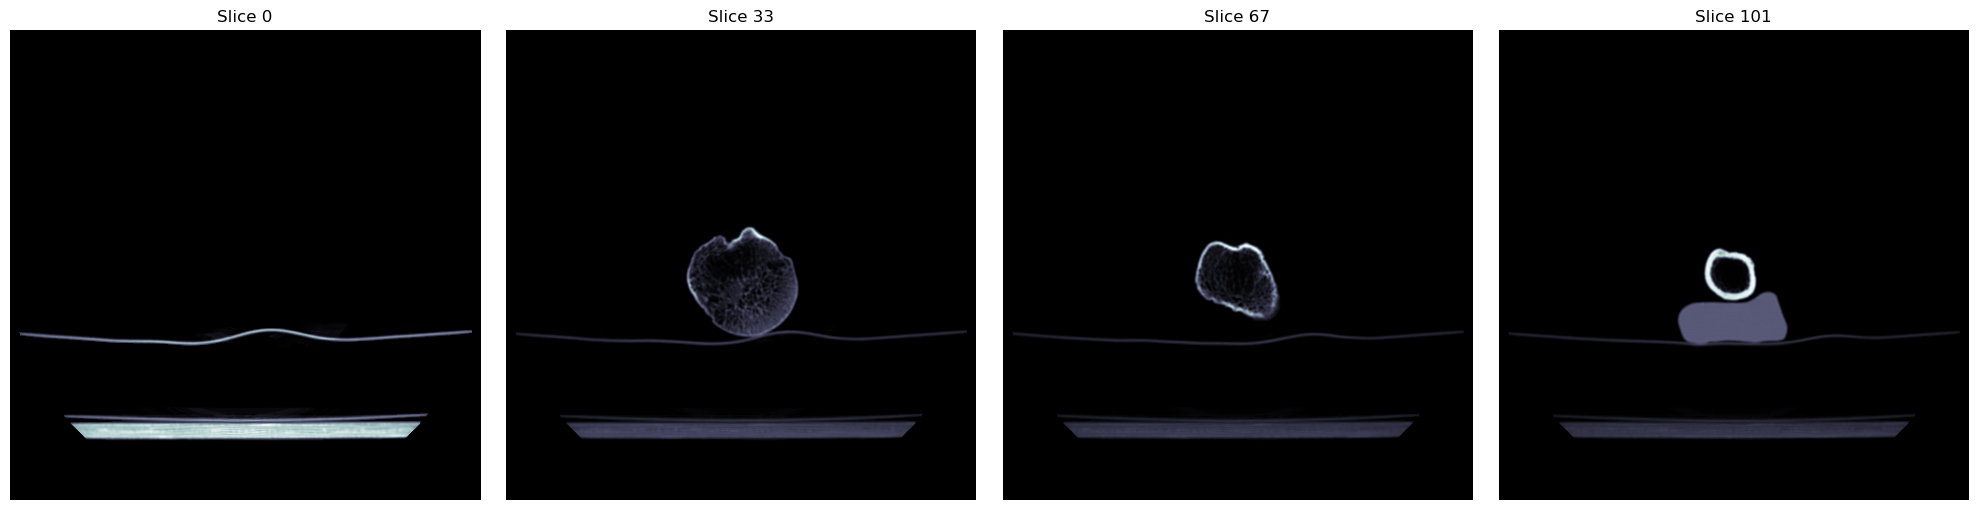

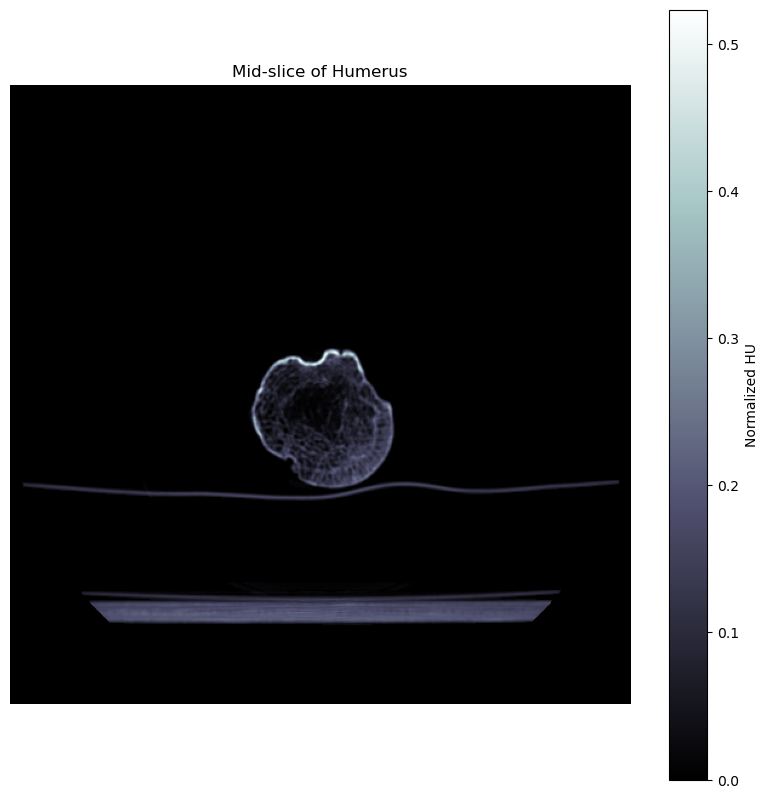

In [37]:
if __name__ == "__main__":
    print(f"Using device: {Config.DEVICE}")
    
    # Initialize dataset
    humerus_dataset = HumerusDataset()
    
    try:
        # Load the volume
        print("Loading humerus CT series...")
        volume, metadata = humerus_dataset.load_series()
        print(f"Loaded volume shape: {volume.shape}")
        print("\nMetadata:")
        for key, value in metadata.items():
            print(f"{key}: {value}")
        
        # Preprocess
        print("\nPreprocessing volume...")
        volume_processed = humerus_dataset.preprocess_volume(volume)
        
        # Visualize
        print("\nVisualizing sample slices...")
        humerus_dataset.visualize_slices(volume_processed)
        
        # Show mid-slice with more detail
        mid_slice = volume_processed[:, :, volume_processed.shape[2]//2]
        plt.figure(figsize=(10, 10))
        plt.imshow(mid_slice, cmap='bone')
        plt.title('Mid-slice of Humerus')
        plt.colorbar(label='Normalized HU')
        plt.axis('off')
        plt.show()
        
    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("\nPlease ensure:")
        print("1. The data directory exists:", Config.DATA_DIR / 'humerus')
        print("2. DICOM files are named like 'hum0001.dcm', 'hum0002.dcm', etc.")
        print("3. There are approximately 102 DICOM files in the series")

## Bone meshing generator

In [28]:
import trimesh
import scipy.interpolate
from skimage import measure
from typing import Tuple

class BoneSegmenter:
    def __init__(self):
        self.device = Config.DEVICE
        # 1. U-Net pour la segmentation
        self.unet = UNet(
            in_channels=1,
            out_channels=1,
            init_features=32
        ).to(self.device)
        
        # Charger les poids pré-entraînés
        checkpoint = torch.load(Config.MODELS_DIR / 'unet_best.pth')
        self.unet.load_state_dict(checkpoint['model_state_dict'])
        self.unet.eval()

    def detect_bone_edges(self, slice_data: np.ndarray) -> np.ndarray:
        """Détection des bords avec U-Net + post-traitement"""
        # Préparation pour U-Net
        input_tensor = torch.from_numpy(slice_data).float()
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
        input_tensor = input_tensor.to(self.device)
        
        with torch.no_grad():
            # 1. Prédiction U-Net
            pred = self.unet(input_tensor)
            pred = torch.sigmoid(pred)
            pred = pred[0, 0].cpu().numpy()
            
            # 2. Post-traitement de la prédiction
            pred_binary = (pred > 0.5).astype(np.uint8)
            
            # 3. Extraction des contours
            contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            if not contours:
                return np.zeros_like(slice_data, dtype=np.uint8)
            
            # 4. Sélection et lissage du meilleur contour
            best_contour = max(contours, key=cv2.contourArea)
            epsilon = 0.002 * cv2.arcLength(best_contour, True)
            smoothed_contour = cv2.approxPolyDP(best_contour, epsilon, True)
            
            # 5. Création du masque final
            contour_mask = np.zeros_like(slice_data, dtype=np.uint8)
            cv2.drawContours(contour_mask, [smoothed_contour], -1, 1, 2)
            
            return contour_mask

    def generate_3d_model(contour_volume: np.ndarray, spacing: Tuple[float, float, float]) -> trimesh.Trimesh:
        """Génère un modèle 3D à partir des contours"""
        print("Creating 3D volume from contours...")
        volume_3d = np.zeros_like(contour_volume, dtype=np.uint8)
        
        # Remplir les contours
        for i in range(contour_volume.shape[2]):
            mask = contour_volume[:, :, i]
            if np.any(mask):
                # Trouver et remplir les contours
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.fillPoly(volume_3d[:, :, i], contours, 1)
        
        # Lissage 3D
        kernel = np.ones((3,3,3), dtype=np.uint8)
        volume_3d = scipy.ndimage.binary_closing(volume_3d, kernel)
        
        # Extraire la surface avec marching cubes
        vertices, faces, normals, _ = measure.marching_cubes(
            volume_3d,
            level=0.5,
            spacing=spacing,
            gradient_direction='descent',
            step_size=1,
            allow_degenerate=False
        )
        
        # Créer le maillage
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, normals=normals)
        
        # Lisser le maillage
        mesh = mesh.smoothed(iterations=3)
        
        return mesh

    def segment_volume(self, volume: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Segmente le volume complet"""
        segmented_volume = np.zeros_like(volume, dtype=np.float32)
        contour_volume = np.zeros_like(volume, dtype=np.uint8)
        
        for i in range(volume.shape[2]):
            slice_data = volume[:, :, i]
            enhanced = self.enhance_bone_contrast(slice_data)
            contours = self.detect_bone_edges(slice_data)
            
            segmented_volume[:, :, i] = enhanced
            contour_volume[:, :, i] = contours
            
            if i % 10 == 0:
                print(f"Processed slice {i}/{volume.shape[2]}")
        
        return segmented_volume, contour_volume

In [30]:
class BoneModel3D:
    def __init__(self):
        self.mesh = None
    
    def generate_3d_model(self, contour_volume: np.ndarray, spacing: Tuple[float, float, float]) -> trimesh.Trimesh:
        """Génère un modèle 3D à partir des contours"""
        print("Creating 3D volume from contours...")
        volume_3d = np.zeros_like(contour_volume, dtype=np.uint8)
        
        # Remplir et connecter les contours
        for i in range(contour_volume.shape[2]):
            mask = contour_volume[:, :, i]
            if np.any(mask):
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.fillPoly(volume_3d[:, :, i], contours, 1)
        
        # Lissage 3D
        kernel = np.ones((3,3,3), dtype=np.uint8)
        volume_3d = scipy.ndimage.binary_closing(volume_3d, kernel)
        
        # Marching cubes
        vertices, faces, normals, _ = measure.marching_cubes(
            volume_3d,
            level=0.5,
            spacing=spacing,
            gradient_direction='descent',
            step_size=1,
            allow_degenerate=False
        )
        
        # Créer et lisser le maillage
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, normals=normals)
        mesh = mesh.smoothed(iterations=3)
        
        self.mesh = mesh
        return mesh
    
    def save_stl(self, output_path: Path):
        """Sauvegarde le maillage en STL"""
        if self.mesh is not None:
            self.mesh.export(str(output_path))